# Trigrams - MakeMore2 (19/04/2023)

In [76]:
# https://youtu.be/TCH_1BHY58I
# https://github.com/karpathy/makemore 

Now we'll try to build a multilayer perceptron (MLP).
Each character is going to be embedded in a 2D space.
We've three vectors 30D, so 90D as total dimension. (28 chars + 2)
Training the network the embedding will change.
We'll have a linear transformation which transpose in an intermediate layer we can see as 100D vector.
Transforming this non-linearly (with a hyperbolic tangent) it will construct the derivatives (back propagation).
With another linear transform we'll connect all.
Exponentiating and normalizing we'll get the desired probability distribution.
Hyperparameters are the a priori defined parameters.
To do things in a good way one needs to know how to tune the hyperparameters.

In [77]:
# we now go to MLP (multilayer perceptron)....(using NLP (natural language processing))
# 'a neural probabilistic language model' (2003) chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/
# https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf
# fig 1: 4th word predicted after the three....
import random
import torch
import torch.nn.functional as  F
import matplotlib.pyplot as plt
%matplotlib inline

In [78]:
# read in all the words
random.seed(158)
words=open('data/nomi_italiani.txt','r').read().splitlines()
random.shuffle(words)
print(words[0:10])
print(len(words))

['argento', 'giovannino', 'licurga', 'elvira', 'marena', 'sirio', 'emilia', 'bisio', 'preziosa', 'perpetua']
9105


In [79]:
# build the vocabulary of characters and mapping to/from integers
chars=sorted(list(set(''.join(words))))

stoi={s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos ={i:s for s,i in stoi.items()}
print(itos)
print(stoi)

{1: '-', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z', 0: '.'}
{'-': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'x': 25, 'y': 26, 'z': 27, '.': 0}


Previous example - Markov chain, so the block size was 1.
Updating the contest means shift over the string and add the last character.
X contains the samples (what I'm looking at).
Each row of X is a trigram.
Y contains the correct answers.

In [80]:
# build the dataset

block_size = 3 #context length: how many characters do we take to predict the next one ... change it !!
# try: block_size=1 ...Markov Chain, then try = 2 and =10
X,Y = [],[]  # input & label

for w in words[0:5]:
    print(w)
    context=[0]*block_size # 000 corresponds to the character '...'
    for ch in w +'.':
        ix=stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context=context[1:]+[ix]  # shift: crop and append
X=torch.tensor(X)
Y=torch.tensor(Y)

argento
... ---> a
..a ---> r
.ar ---> g
arg ---> e
rge ---> n
gen ---> t
ent ---> o
nto ---> .
giovannino
... ---> g
..g ---> i
.gi ---> o
gio ---> v
iov ---> a
ova ---> n
van ---> n
ann ---> i
nni ---> n
nin ---> o
ino ---> .
licurga
... ---> l
..l ---> i
.li ---> c
lic ---> u
icu ---> r
cur ---> g
urg ---> a
rga ---> .
elvira
... ---> e
..e ---> l
.el ---> v
elv ---> i
lvi ---> r
vir ---> a
ira ---> .
marena
... ---> m
..m ---> a
.ma ---> r
mar ---> e
are ---> n
ren ---> a
ena ---> .


In [81]:
print(X)
print(Y)

tensor([[ 0,  0,  0],
        [ 0,  0,  2],
        [ 0,  2, 19],
        [ 2, 19,  8],
        [19,  8,  6],
        [ 8,  6, 15],
        [ 6, 15, 21],
        [15, 21, 16],
        [ 0,  0,  0],
        [ 0,  0,  8],
        [ 0,  8, 10],
        [ 8, 10, 16],
        [10, 16, 23],
        [16, 23,  2],
        [23,  2, 15],
        [ 2, 15, 15],
        [15, 15, 10],
        [15, 10, 15],
        [10, 15, 16],
        [ 0,  0,  0],
        [ 0,  0, 13],
        [ 0, 13, 10],
        [13, 10,  4],
        [10,  4, 22],
        [ 4, 22, 19],
        [22, 19,  8],
        [19,  8,  2],
        [ 0,  0,  0],
        [ 0,  0,  6],
        [ 0,  6, 13],
        [ 6, 13, 23],
        [13, 23, 10],
        [23, 10, 19],
        [10, 19,  2],
        [ 0,  0,  0],
        [ 0,  0, 14],
        [ 0, 14,  2],
        [14,  2, 19],
        [ 2, 19,  6],
        [19,  6, 15],
        [ 6, 15,  2]])
tensor([ 2, 19,  8,  6, 15, 21, 16,  0,  8, 10, 16, 23,  2, 15, 15, 10, 15, 16,
         0, 13, 1

In [82]:
print(X.shape, X.dtype, Y.shape, Y.dtype)

torch.Size([41, 3]) torch.int64 torch.Size([41]) torch.int64


Now we want to predict the next character starting from trigrams.
We're going to take a 2D embedding of the 28 characters.
There are many pre-calculated embeddings in the world.

We can generate a random (normal) matrix 28x2.
In deep data analysis (what we're doing) the world is going really fast.
There is a lot of material, 99% of which are bullshits.

In [83]:
C = torch.randn((28,2))  #https://pytorch.org/docs/stable/generated/torch.randn.html

In [84]:
print(C[5])
print(C.shape)

tensor([-0.1387, -0.5640])
torch.Size([28, 2])


Here is a plot of the embedding.
Letters are random, after the training this picture is going to change.
From this plot we can learn how characters are related each other.

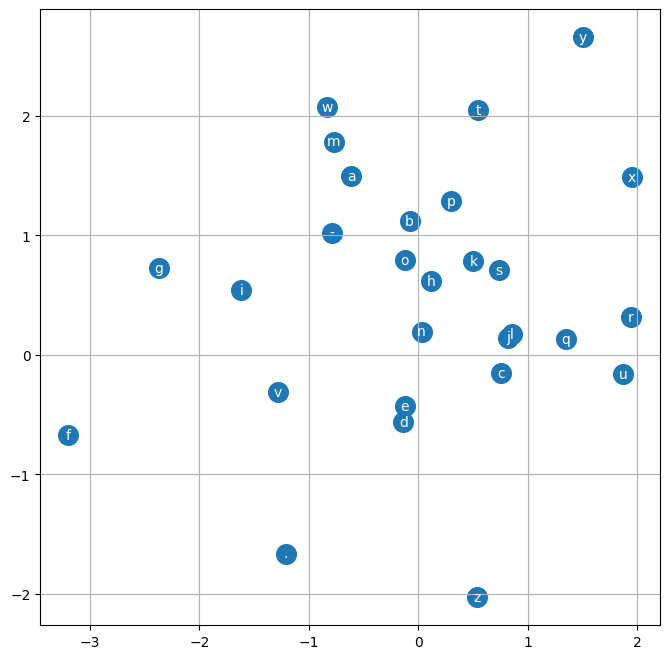

In [85]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data,s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(),itos[i], ha="center",va="center", color="white")
    plt.grid('minor')


Another way to embed characters is the one-hot embedding discussed last lecture.
We can see this embedding as the first layer of our network, even if there's no linearity in it.
In fact, they're completely equivalent.
One can also see all the embeddings.

In [86]:
print(F.one_hot(torch.tensor(5),num_classes=28))
print(F.one_hot(torch.tensor(5),num_classes=28).float()@C)
print(C[5])
print(C[Y])

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])
tensor([-0.1387, -0.5640])
tensor([-0.1387, -0.5640])
tensor([[-0.6134,  1.4951],
        [ 1.9421,  0.3166],
        [-2.3731,  0.7239],
        [-0.1259, -0.4294],
        [ 0.0294,  0.1952],
        [ 0.5444,  2.0474],
        [-0.1258,  0.7940],
        [-1.2109, -1.6624],
        [-2.3731,  0.7239],
        [-1.6162,  0.5438],
        [-0.1258,  0.7940],
        [-1.2823, -0.3096],
        [-0.6134,  1.4951],
        [ 0.0294,  0.1952],
        [ 0.0294,  0.1952],
        [-1.6162,  0.5438],
        [ 0.0294,  0.1952],
        [-0.1258,  0.7940],
        [-1.2109, -1.6624],
        [ 0.8539,  0.1744],
        [-1.6162,  0.5438],
        [ 0.7506, -0.1500],
        [ 1.8679, -0.1604],
        [ 1.9421,  0.3166],
        [-2.3731,  0.7239],
        [-0.6134,  1.4951],
        [-1.2109, -1.6624],
        [-0.1259, -0.4294],
        [ 0.8539,  0.1744],
        [-1.2823, -0.3096],
     

How to embed the 41 trigrams we have?

In [87]:
emb = C[X]
print(emb.shape)

torch.Size([41, 3, 2])


Moreover, we can *differentiate* C!
Input has dimension 6 = 3 * 2

In [88]:
# construct the Layer.... x.W+ b ... so the input has dimension 6=3*2 for (say) 100 neurons...
W1 = torch.randn(6,100)
b1 = torch.randn(100)


We want to concatenate tensors.
And maybe unbind them.

In [89]:
# https://pytorch.org/docs/stable/torch.html search for concatenate...

print(torch.cat([emb[:,0,:],emb[:,1,:],emb[:,2,:]],1)[1])
print(emb[1])
#torch.cat([emb[:,0,:],emb[:,1,:],emb[:,2,:]],1).shape


tensor([-1.2109, -1.6624, -1.2109, -1.6624, -0.6134,  1.4951])
tensor([[-1.2109, -1.6624],
        [-1.2109, -1.6624],
        [-0.6134,  1.4951]])


In [90]:
# we want a code for general n-grams..... 
# use 'unbind' https://pytorch.org/docs/stable/generated/torch.unbind.html#torch.unbind
len(torch.unbind(emb,1))


3

In [91]:
# and this work fore any context length.......

torch.cat(torch.unbind(emb,1),1)

tensor([[-1.2109, -1.6624, -1.2109, -1.6624, -1.2109, -1.6624],
        [-1.2109, -1.6624, -1.2109, -1.6624, -0.6134,  1.4951],
        [-1.2109, -1.6624, -0.6134,  1.4951,  1.9421,  0.3166],
        [-0.6134,  1.4951,  1.9421,  0.3166, -2.3731,  0.7239],
        [ 1.9421,  0.3166, -2.3731,  0.7239, -0.1259, -0.4294],
        [-2.3731,  0.7239, -0.1259, -0.4294,  0.0294,  0.1952],
        [-0.1259, -0.4294,  0.0294,  0.1952,  0.5444,  2.0474],
        [ 0.0294,  0.1952,  0.5444,  2.0474, -0.1258,  0.7940],
        [-1.2109, -1.6624, -1.2109, -1.6624, -1.2109, -1.6624],
        [-1.2109, -1.6624, -1.2109, -1.6624, -2.3731,  0.7239],
        [-1.2109, -1.6624, -2.3731,  0.7239, -1.6162,  0.5438],
        [-2.3731,  0.7239, -1.6162,  0.5438, -0.1258,  0.7940],
        [-1.6162,  0.5438, -0.1258,  0.7940, -1.2823, -0.3096],
        [-0.1258,  0.7940, -1.2823, -0.3096, -0.6134,  1.4951],
        [-1.2823, -0.3096, -0.6134,  1.4951,  0.0294,  0.1952],
        [-0.6134,  1.4951,  0.0294,  0.1

Let's see a better way.

In [92]:
# https://pytorch.org/docs/stable/generated/torch.Tensor.view.html

# https://pytorch.org/docs/stable/generated/torch.Tensor.stride.html

# use google image and discuss in class....

a = torch.arange(18)
print(a)
print(a.shape)
print(a.view(9, 2))
print(a.view(2, 9))
print(a.storage()) # very efficient in torch

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])
torch.Size([18])
tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17]])
tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])
 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]


/tmp/ipykernel_1012/1622729900.py:12: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  print(a.storage()) # very efficient in torch
/home/grufoony/.local/lib/python3.10/site-packages/torch/storage.py:636: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  f'device={self.device}) of size {len(self)}]')
/home/grufoony/.local/lib/python3.10/site-packages/torch/storage.py:637: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter t

In [93]:
print(emb.view(41,6) == torch.cat(torch.unbind(emb,1),1))

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [94]:
# so we can use

h = emb.view(41,6) @ W1 + b1

In [95]:
print(h)
print(h.shape)
print(emb.view(-1,6) @ W1 + b1)

tensor([[-1.3045, -0.7865, -6.5908,  ...,  4.3257,  5.5680, -0.5335],
        [-0.0945,  1.4466,  0.9729,  ..., -0.4750,  0.1975, -2.7062],
        [-6.2852, -7.0725, -4.0863,  ..., -1.9283, -0.7651, -2.9161],
        ...,
        [ 2.4809, -0.8315, -1.6788,  ..., -0.8159, -1.6434,  1.4737],
        [ 2.5818,  2.8563,  1.4082,  ...,  0.6870,  2.8445,  0.3858],
        [-0.5759,  1.0345,  2.3659,  ..., -1.1661, -1.2980, -0.6029]])
torch.Size([41, 100])
tensor([[-1.3045, -0.7865, -6.5908,  ...,  4.3257,  5.5680, -0.5335],
        [-0.0945,  1.4466,  0.9729,  ..., -0.4750,  0.1975, -2.7062],
        [-6.2852, -7.0725, -4.0863,  ..., -1.9283, -0.7651, -2.9161],
        ...,
        [ 2.4809, -0.8315, -1.6788,  ..., -0.8159, -1.6434,  1.4737],
        [ 2.5818,  2.8563,  1.4082,  ...,  0.6870,  2.8445,  0.3858],
        [-0.5759,  1.0345,  2.3659,  ..., -1.1661, -1.2980, -0.6029]])


Embed (glue) + apply matrix + add b1

In [96]:
# first layer

# https://pytorch.org/docs/stable/generated/torch.tanh.html

h = torch.tanh(emb.view(-1,6) @ W1 + b1)

In [97]:
print(h)

tensor([[-0.8629, -0.6564, -1.0000,  ...,  0.9997,  1.0000, -0.4880],
        [-0.0942,  0.8950,  0.7500,  ..., -0.4422,  0.1950, -0.9911],
        [-1.0000, -1.0000, -0.9994,  ..., -0.9586, -0.6441, -0.9942],
        ...,
        [ 0.9861, -0.6813, -0.9327,  ..., -0.6728, -0.9280,  0.9003],
        [ 0.9886,  0.9934,  0.8871,  ...,  0.5960,  0.9933,  0.3677],
        [-0.5197,  0.7757,  0.9825,  ..., -0.8230, -0.8612, -0.5391]])


Second layer must take in 100D vector and give out a 28D vector.

In [98]:
# second layer
    
W2 = torch.randn((100,28))
b2 = torch.randn(28)

h is coming out from the first layer, then we feed with h the layer here.

In [99]:
logits= h @ W2 +b2
print(logits.shape)

torch.Size([41, 28])


Logits means log of the counting...

In [100]:
counts = logits.exp()

Normalize to interpret this as a measure, i.e. a probability distribution coming out from the network when fed with three chars.

In [101]:
prob = counts / counts.sum(1,keepdims=True)

In [102]:
print(prob[0])
print(prob[0].sum())
print(prob[0, 1])
print(prob[[0,1],[2,5]])

tensor([3.0773e-08, 3.3734e-06, 5.9390e-08, 1.5905e-06, 1.0303e-05, 3.2433e-08,
        9.8882e-09, 3.6893e-08, 7.6286e-07, 2.1819e-05, 8.0904e-04, 2.8643e-09,
        4.5660e-12, 2.8235e-05, 3.6545e-13, 8.6095e-04, 4.5056e-05, 1.8306e-04,
        3.8159e-12, 2.1595e-04, 2.7025e-05, 9.9708e-01, 3.9288e-12, 6.9774e-04,
        1.5863e-05, 9.7494e-09, 4.0138e-11, 2.1206e-10])
tensor(1.)
tensor(3.3734e-06)
tensor([5.9390e-08, 2.3458e-18])


Model is initialized with random weights, so it's making mistakes.

In [103]:
print(Y)
print(torch.arange(41))
print(prob[torch.arange(41),Y])

tensor([ 2, 19,  8,  6, 15, 21, 16,  0,  8, 10, 16, 23,  2, 15, 15, 10, 15, 16,
         0, 13, 10,  4, 22, 19,  8,  2,  0,  6, 13, 23, 10, 19,  2,  0, 14,  2,
        19,  6, 15,  2,  0])
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40])
tensor([5.9390e-08, 8.8858e-11, 1.2132e-05, 4.9871e-08, 3.3685e-09, 4.7157e-01,
        9.3018e-06, 2.0276e-06, 7.6286e-07, 7.0948e-12, 5.6750e-07, 1.3505e-12,
        1.9376e-08, 3.5265e-07, 1.3190e-04, 2.3236e-06, 1.3412e-01, 1.9459e-09,
        1.7078e-03, 2.8235e-05, 3.7713e-05, 4.3189e-12, 2.7178e-18, 1.2909e-05,
        3.0720e-09, 1.9949e-09, 6.6161e-16, 9.8882e-09, 6.7945e-12, 3.7141e-01,
        1.0150e-08, 9.0557e-12, 2.2180e-07, 2.6731e-07, 3.6545e-13, 6.4834e-15,
        5.9562e-06, 9.0961e-10, 3.1156e-10, 1.1032e-04, 5.6778e-10])


We, of course, want the model to predict the right answer.
Probability going to one implies loss going to zero.

In [104]:
loss = - prob[torch.arange(41),Y].log().mean()
print(loss)  # very bad of course.....

tensor(17.4706)


Let's put things together.
Parameters will contain all the objects we're going to change.

In [105]:
g = torch.Generator().manual_seed(123456780)# for reproducibility
C = torch.randn((28,2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,28), generator=g)
b2 = torch.randn(28, generator=g)
parameters = [C,W1,b1,W2,b2]

How many parameters are fixable?

In [106]:
print(sum(p.nelement() for p in parameters)) # number of parameter in total...

3584


In [107]:
emb = C[X] # torch.Size([41, 3, 2])
h = torch.tanh(emb.view(-1,6) @ W1 + b1) #(41,100)
logits = h @ W2 + b2 #(41,27)
counts = logits.exp()
prob = counts/counts.sum(1,keepdims=True)
loss = -prob[torch.arange(41),Y].log().mean()
print(loss)

tensor(17.2342)


In [108]:
# we can make it more efficient using the build in cross entropy loss function...
print(F.cross_entropy(logits,Y))

tensor(17.2342)


Now the loss has to be minimized.

In [109]:
# so..... https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html
emb = C[X] # torch.Size([41, 3, 2])
h = torch.tanh(emb.view(-1,6) @ W1 + b1) #(41,100)
logits = h @ W2 + b2 #(41,27)
#counts=logits.exp()
#prob=counts/counts.sum(1,keepdims=True)
#loss=-prob[torch.arange(41),Y].log().mean()
loss = F.cross_entropy(logits,Y)
print(loss)

tensor(17.2342)


We'll use the cross_entropy function because the exponentiation of just -500 will result in 0

In [110]:
# two very good reasons to use 'cross_entropy': more efficient (no tensor) and substract the maximum to avoid nan....discuss....

logits = torch.tensor([-5,-3,0,10]) # -100
counts = logits.exp()
prob = counts/counts.sum()
print(counts)
print(prob)

tensor([6.7379e-03, 4.9787e-02, 1.0000e+00, 2.2026e+04])
tensor([3.0589e-07, 2.2602e-06, 4.5398e-05, 9.9995e-01])


Put the gradient to zero, then compute the backward derivative and update all parameters in order to decrease the loss.

In [111]:
for p in parameters:
    p.requires_grad = True

for _ in range(1000):
    # now we learn...forward bass 
    emb = C[X] # torch.Size([41, 3, 2])
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) #(41,100)
    logits = h @ W2 + b2 #(41,27)
    loss = F.cross_entropy(logits,Y)
    # backward pass 
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -0.1*p.grad

In [112]:
# sampling from the model.....

g = torch.Generator().manual_seed(12345678+10)

for _ in range(20):
    out = []
    context = [0]*block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1) 
        logits = h @ W2 + b2
        probs = F.softmax(logits,dim=1)
        ix = torch.multinomial(probs,num_samples=1,generator=g).item()
        context = context[1:]+[ix]
        out.append(ix)
        if ix==0:
            break
        
    print(''.join(itos[i] for i in out))
        

elvira.
marena.
giovannino.
giovannino.
giovannino.
giovannino.
elvira.
marena.
argento.
argento.
argento.
elvira.
argento.
licurga.
licurga.
marena.
giovannino.
marena.
giovannino.
licurga.


Model is overfitting: we've given it only 5 samples out of 7000+...
Actually we've 41 examples (trigrams) and 3584 parameters.

In [113]:
for p in parameters:
    p.requires_grad = True

for _ in range(1000):
    # now we learn...forward bass 
    emb = C[X] # torch.Size([41, 3, 2])
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) #(41,100)
    logits = h @ W2 + b2 #(41,27)
    loss = F.cross_entropy(logits,Y)
    #print(loss.item())
    # backward pass 
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
    for p in parameters:
        p.data += -0.1*p.grad
print(loss.item())

0.19916315376758575


In [114]:
print(logits.max(1))
print(Y)

torch.return_types.max(
values=tensor([12.1724, 14.1847, 15.8096, 16.5460, 12.5090, 14.7062, 15.2590, 15.4024,
        12.1724, 19.3660, 15.9274, 12.4720, 13.9841, 17.1356, 14.9285, 13.9812,
        13.8305, 15.1462, 14.5532, 12.1724, 15.2042, 17.6397, 14.6976, 14.7785,
        22.7934, 18.4190, 15.3254, 12.1724, 18.8153, 16.9008, 17.9443, 18.5473,
        15.9427, 15.7163, 12.1724, 19.9722, 15.4614, 16.7053, 16.1372, 18.4218,
        15.9050], grad_fn=<MaxBackward0>),
indices=tensor([13, 19,  8,  6, 15, 21, 16,  0, 13, 10, 16, 23,  2, 15, 15, 10, 15, 16,
         0, 13, 10,  4, 22, 19,  8,  2,  0, 13, 13, 23, 10, 19,  2,  0, 13,  2,
        19,  6, 15,  2,  0]))
tensor([ 2, 19,  8,  6, 15, 21, 16,  0,  8, 10, 16, 23,  2, 15, 15, 10, 15, 16,
         0, 13, 10,  4, 22, 19,  8,  2,  0,  6, 13, 23, 10, 19,  2,  0, 14,  2,
        19,  6, 15,  2,  0])


Taking all words we get a very big example dataset.

In [115]:
block_size = 3 #context length: how many characters do we take to predict the next one ... change it !!
X, Y = [], []  # input & label

for w in words:
  #  print(w)
    context = [0]*block_size
    for ch in w +'.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
      #  print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:]+[ix]  # shift: crop and append
X=torch.tensor(X)
Y=torch.tensor(Y)

In [116]:
print(X.shape, Y.shape)

torch.Size([73643, 3]) torch.Size([73643])


In [117]:
# exactly as before....
g = torch.Generator().manual_seed(123456780)# for reproducibility
C = torch.randn((28,2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,28), generator=g)
b2 = torch.randn(28, generator=g)
parameters = [C,W1,b1,W2,b2]

In [118]:
for p in parameters:
    p.requires_grad = True

for _ in range(10):
    # now we learn...forward bass -- = 73643
    emb = C[X] # torch.Size([--, 3, 2])
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) #(--,100)
    logits = h @ W2 + b2 #(--,27)
    loss = F.cross_entropy(logits,Y)
    print(loss.item())
    # backward pass 
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
    for p in parameters:
        p.data += -0.1*p.grad
print(loss.item())

17.754497528076172
15.824398040771484
14.187442779541016
13.052314758300781
12.071905136108398
11.26384162902832
10.603142738342285
10.075033187866211
9.627379417419434
9.222493171691895
9.222493171691895


See how it's slowing down...
Every time we give all samples to it.
Let's subdivide the dataset in batches.

In [119]:
ix=torch.randint(0, X.shape[0], (10,)) #try ix=torch.randint(0,X.shape[0],(10,2)) and explain
#https://pytorch.org/docs/stable/generated/torch.randint.html
print(ix)

tensor([ 3406, 40709, 54717, 56273, 51644,  1443, 70213, 23916,  1380, 24011])


In [120]:
ix=torch.randint(0, X.shape[0], (10,1))
print(ix)

tensor([[ 3079],
        [60335],
        [27994],
        [72581],
        [52896],
        [34230],
        [65276],
        [22427],
        [48644],
        [21171]])


In [121]:
for _ in range(10):
    # mini batch construct of size ...
    ix = torch.randint(0,X.shape[0],(32,))
    # now we learn...forward bass -- = 73643
    emb = C[X[ix]] # torch.Size([--, 3, 2])
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) #(--,100)
    logits = h @ W2 + b2 #(--,27)
    loss = F.cross_entropy(logits,Y[ix])
    print(loss.item())
    # backward pass 
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
    for p in parameters:
        p.data += -0.1*p.grad
print(loss.item())

7.30229377746582
9.417058944702148
5.193726539611816
6.689864635467529
8.469709396362305
8.550464630126953
8.491397857666016
8.364103317260742
5.644956111907959
5.984501361846924
5.984501361846924


In [122]:
# how we define the 'learning rate' ? p.data += -0.1*p.grad
# play with learning rate from .01 to 100.... and discuss

In [123]:
for _ in range(50):  
    # mini batch construct
    ix = torch.randint(0,X.shape[0],(100,))
    # now we learn...forward bass -- = 73643
    emb = C[X[ix]] # torch.Size([--, 3, 2])
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) #(--,100)
    logits = h @ W2 + b2 #(--,27)
    loss = F.cross_entropy(logits,Y[ix])
    print(loss.item())
    # backward pass 
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
    for p in parameters:
        p.data += -.1*p.grad
#print(loss.item())

6.352814197540283
5.745189666748047
5.619042873382568
5.047020435333252
6.099915027618408
5.776467800140381
6.162656784057617
5.84634256362915
5.1438798904418945
4.591708183288574
5.034064769744873
4.842540740966797
4.109856128692627
4.809081554412842
4.829516887664795
4.298920154571533
4.443389892578125
4.66321325302124
4.386630535125732
4.707630634307861
4.1620988845825195
4.900666236877441
3.9293692111968994
4.090272426605225
4.326892375946045
3.888510227203369
3.7192318439483643
3.7005066871643066
3.776442766189575
3.537832021713257
4.038181781768799
4.225849628448486
3.707176446914673
3.4348883628845215
3.7892093658447266
3.621366024017334
3.710712194442749
4.205099105834961
3.7120473384857178
3.945746421813965
3.1517748832702637
3.506485939025879
3.8938164710998535
3.5666685104370117
3.9406888484954834
3.7563321590423584
3.9478847980499268
3.4152672290802
3.301408290863037
3.3562445640563965


In [124]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre
print(lrs.shape)

torch.Size([1000])


In [125]:
for p in parameters:
    p.requires_grad = True
    
lri = []
lriex = []
lossi = []
    

for i in range(1000):
    # mini batch construct
    ix = torch.randint(0,X.shape[0],(100,))
    # now we learn...forward bass -- = 73643
    emb = C[X[ix]] # torch.Size([--, 3, 2])
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) #(--,100)
    logits = h @ W2 + b2 #(--,27)
    loss = F.cross_entropy(logits,Y[ix])
    print(i,loss.item())
    # backward pass 
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
    lr = lrs[i]
    # lr= .01
    for p in parameters:
        p.data += -lr*p.grad
#print(loss.item())

#track stats
    lri.append(lr)
    lriex.append(lre[i])
    lossi.append(loss.item())

0 3.6702959537506104
1 3.4717462062835693
2 3.8229663372039795
3 3.269500494003296
4 3.497579336166382
5 3.3738362789154053
6 3.536966323852539
7 3.5905911922454834
8 3.3715546131134033
9 3.2676877975463867
10 3.2474236488342285
11 3.3944809436798096
12 3.545369863510132
13 3.052788019180298
14 3.257672071456909
15 3.212407112121582
16 3.4199962615966797
17 3.407318353652954
18 3.3791232109069824
19 3.1567492485046387
20 3.988377094268799
21 3.369558811187744
22 3.3583288192749023
23 3.0475058555603027
24 3.177821159362793
25 3.3432602882385254
26 3.536677598953247
27 3.399963617324829
28 3.4546027183532715
29 3.355734348297119
30 3.409982204437256
31 3.0014843940734863
32 2.945284366607666
33 3.528552770614624
34 3.026615858078003
35 3.4188954830169678
36 3.328660011291504
37 3.5925967693328857
38 2.9964160919189453
39 3.8644118309020996
40 3.4175937175750732
41 3.1122047901153564
42 3.11641788482666
43 3.54695463180542
44 3.705383062362671
45 3.520034074783325
46 3.145904779434204
47

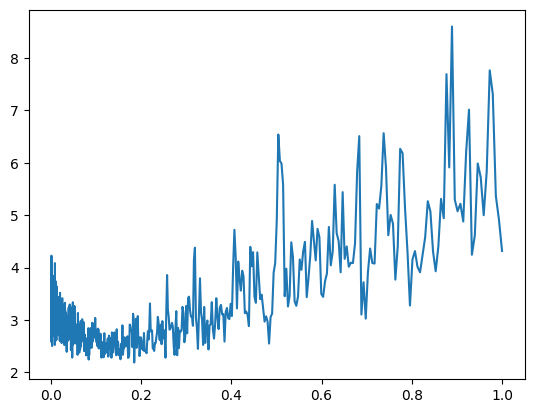

In [126]:
plt.plot(lri, lossi)  # discuss......

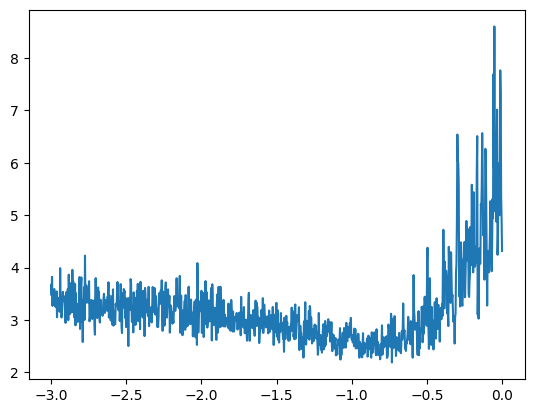

In [127]:
plt.plot(lriex, lossi)  # discuss......

In [128]:
# we can do already much better than bigram....almost...remember overfitting.... 

emb = C[X] # torch.Size([41, 3, 2])
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (41,100)
logits = h @ W2 + b2 # (41,27)
loss = F.cross_entropy(logits,Y)
print(loss)

tensor(4.5970, grad_fn=<NllLossBackward0>)


In [129]:
# training split, dev/validation split (for hypermarameters !!), test split
# 80%, 10%, 10%
# be careful with the test eugene.....

def build_dataset(words):
    block_size = 3 #context length: how many characters do we take to predict the next one ... change it !!
    X, Y = [], []  # input & label

   
    for w in words:
        context = [0]*block_size
        for ch in w +'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
      #  print(''.join(itos[i] for i in context), '--->', itos[ix])
            context=context[1:]+[ix]  # shift: crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [130]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([58867, 3]) torch.Size([58867])
torch.Size([7404, 3]) torch.Size([7404])
torch.Size([7372, 3]) torch.Size([7372])


In [131]:
# and we do it again with the new datasets.......
print(Xtr.shape, Ytr.shape)

# exactly as before....
g = torch.Generator().manual_seed(123456780) # for reproducibility
C = torch.randn((28,2), generator=g)
W1 = torch.randn((6,100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,28), generator=g)
b2 = torch.randn(28, generator=g)
parameters = [C,W1,b1,W2,b2]

torch.Size([58867, 3]) torch.Size([58867])


In [132]:
for p in parameters:
    p.requires_grad = True
    
    
lre = torch.linspace(-3,0,1000)
lrs = 10**lre

In [133]:
# now we train only on Xtr

lri = []
lriex = []
lossi = []
    

for i in range(10000):
    # mini batch construct
    ix = torch.randint(0,Xtr.shape[0],(40,))
    # now we learn...forward bass -- = 73643
    emb = C[Xtr[ix]] # torch.Size([--, 3, 2])
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) #(--,100)
    logits = h @ W2 + b2 #(--,27)
    loss = F.cross_entropy(logits,Ytr[ix])
   # print(i,loss.item())
    # backward pass 
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
    #lr=lrs[i]
    lr= .1
    for p in parameters:
        p.data += -lr*p.grad
print(loss.item())

#track stats
#    lri.append(lr)
#    lriex.append(lre[i])
#    lossi.append(loss.item())

2.2618954181671143


In [134]:
# now we evaluate on Xdev
emb = C[Xdev]
h = torch.tanh(emb.view(-1,6) @ W1 + b1) #(--,100)
logits = h @ W2 + b2 #(--,27)
loss = F.cross_entropy(logits,Ydev)
print(loss)

tensor(2.1950, grad_fn=<NllLossBackward0>)


In [135]:
# now we evaluate on Xtr..... we are NOT overfitting
emb = C[Xtr]
h = torch.tanh(emb.view(-1,6) @ W1 + b1) #(--,100)
logits = h @ W2 + b2 #(--,27)
loss = F.cross_entropy(logits,Ytr)
print(loss)

tensor(2.1753, grad_fn=<NllLossBackward0>)


In [136]:
g = torch.Generator().manual_seed(123456780)# for reproducibility
C = torch.randn((28,2), generator=g)
W1 = torch.randn((6,300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300,28), generator=g)
b2 = torch.randn(28, generator=g)
parameters = [C,W1,b1,W2,b2]

In [137]:
print(sum(p.nelement() for p in parameters)) # number of parameter in total... before 3584

10584


In [138]:
lri = []
lriex = []
lossi = []
stepi = []
for p in parameters:
    p.requires_grad = True

for i in range(10000):
    # mini batch construct
    ix = torch.randint(0,Xtr.shape[0],(40,))
    # now we learn...forward bass -- = 73643
    emb = C[Xtr[ix]] # torch.Size([--, 3, 2])
    h = torch.tanh(emb.view(-1,6) @ W1 + b1) #(--,100)
    logits = h @ W2 + b2 #(--,27)
    loss = F.cross_entropy(logits,Ytr[ix])
    # backward pass 
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
    #lr=lrs[i]
    lr= .1
    for p in parameters:
        p.data += -lr*p.grad
    stepi.append(i)
    lossi.append(loss.item())

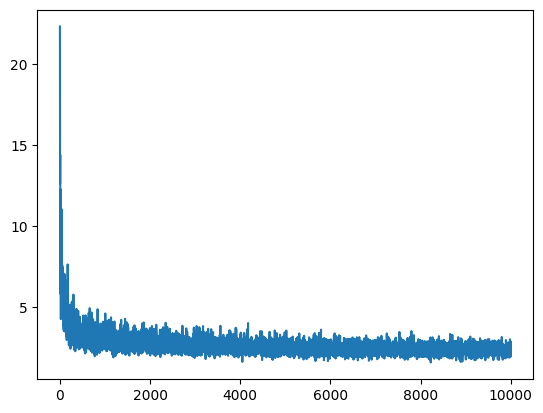

In [139]:
plt.plot(stepi,lossi)

Now we can visualize the result of the embedding.

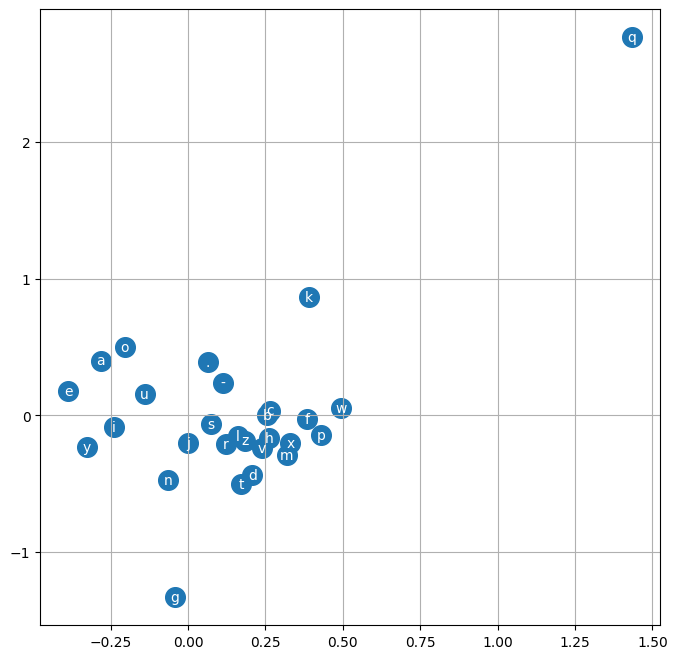

In [140]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(),itos[i], ha="center",va="center", color="white")
    plt.grid('minor')

In [141]:
# we scale up the embedding dimension and see what happen


g = torch.Generator().manual_seed(123456780)# for reproducibility
C = torch.randn((28,10), generator=g)
W1 = torch.randn((30,200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200,28), generator=g)
b2 = torch.randn(28, generator=g)
parameters = [C,W1,b1,W2,b2]

In [142]:
print(sum(p.nelement() for p in parameters)) # number of parameter in total

12108


In [143]:
lri = []
lriex = []
lossi = []
stepi = []

for p in parameters:
    p.requires_grad = True

In [144]:
# do lr =0.1 and then 0.01 and look at the performance....


for i in range(200000):
    
    # mini batch construct
    ix = torch.randint(0,Xtr.shape[0], (40,))
    # now we learn...forward bass -- = 73643
    emb = C[Xtr[ix]] # torch.Size([--, 3, 2])
    h = torch.tanh(emb.view(-1,30) @ W1 + b1) #(--,100)
    logits = h @ W2 + b2 #(--,27)
    loss = F.cross_entropy(logits, Ytr[ix])
    # backward pass 
    for p in parameters:
        p.grad=None
    loss.backward()
    #update
    #lr=lrs[i]
    lr= .1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad
    stepi.append(i)
    lossi.append(loss.log10().item()) # note the log10 !!

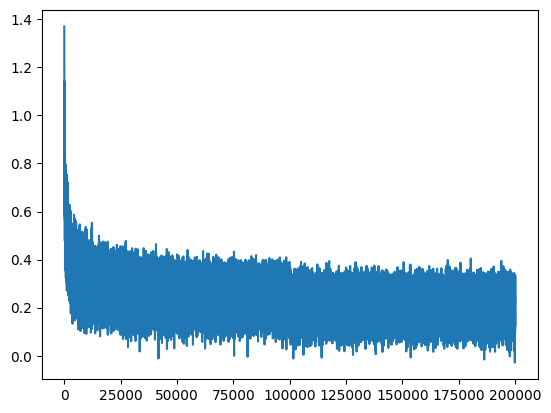

In [145]:
plt.plot(stepi, lossi)

In [146]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1,30) @ W1 + b1) #(--,100)   30 not 6 !
logits = h @ W2 + b2 #(--,27)
loss = F.cross_entropy(logits, Ytr)
print(loss)

tensor(1.6377, grad_fn=<NllLossBackward0>)


In [147]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1,30) @ W1 + b1) #(--,100)
logits = h @ W2 + b2 #(--,27)
loss = F.cross_entropy(logits, Ydev)
print(loss)

tensor(1.8488, grad_fn=<NllLossBackward0>)


Once trained the model we can sample from it.
**NOTE**: there are many (many many) hyperparameters to play with, like the number of layer, numbers of neurons from layers, embedding dimensions, dimension of the batches, learning rate....

In [148]:
g = torch.Generator().manual_seed(12345678+10)

for _ in range(30):
    out = []
    context = [0]*block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1) 
        logits = h @ W2 + b2
        probs = F.softmax(logits,dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:]+[ix]
        out.append(ix)
        if ix == 0:
            break
        
    print(''.join(itos[i] for i in out))    

albo.
giovato.
fridalminia.
gorano.
adelfina.
nenotella.
gero.
brancenza.
nicida.
ivea.
sandri.
mondiano.
levia.
bella.
benice.
orvinaldina.
florida.
ernalidionando.
masantillegidalchia.
giulio.
uliarda.
diminio.
illo.
fio.
opcosto.
pificio.
illa.
mimminia.
rudino.
cleona.
